In [1]:
import numpy as np
import cv2
import os
import pandas as pd
from PIL import Image
import h5py
import matplotlib.pyplot as plt
from scipy import io
from time import time
import sys
from sklearn.model_selection import train_test_split
from helper_functions.data import write_h5, read_h5_numpy
from typing import List, Optional
import requests
import io
import gzip
import shutil
from tqdm import tqdm 
from pathlib import Path
from torch.utils.data import DataLoader
print(os.getcwd())

/var/folders/1z/0p630gzs7zv8cgz4xtmr08pr0000gn/T/ipykernel_4527/4047733874.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


/Users/matte/Documents/RESEARCH/PyTorch-Lightning-template/notebooks


In [2]:

def download_dataset(
        url, 
        chunk_size=128,
        labels = False):
    try:
        r = requests.get(url, stream=True)
    except:
        r = requests.get(url, stream=True, verify=False)

    if labels == False:
        out = np.frombuffer(
            gzip.decompress(r.content), 
            dtype=np.uint8,
            offset=16)
        out = out.reshape(int(out.shape[0]/784), 784)
    else:
        out = np.frombuffer(
            gzip.decompress(r.content), 
            dtype=np.uint8,
            offset=8)
            
    
    # imgpath = gzip.open('tmp.gz', 'rb')
    # imgpath.read()

    # if labels == False:
    #     with gzip.open('tmp.gz', 'rb') as imgpath:
    #         out = np.frombuffer(
    #             imgpath.read(), 
    #             dtype=np.uint8,
    #             offset=16)
    #     out = out.reshape(int(out.shape[0]/784), 784)
    # else:
    #     with gzip.open('tmp.gz', 'rb') as imgpath:
    #         out = np.frombuffer(
    #             imgpath.read(), 
    #             dtype=np.uint8,
    #             offset=8)
        
    # os.remove('tmp.gz')
        
    return out


### Train dataset
print(' Downloading and extracting train images ...')
images_train = download_dataset(
    url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
)

print(' Downloading and extracting train labels ...')
labels_train = download_dataset(
    url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz",
    labels = True
)


### Test dataset
print(' Downloading and extracting test images ...')
images_test = download_dataset(
    url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
)

print(' Downloading and extracting test labels ...')
labels_test = download_dataset(
    url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz",
    labels = True
)



In [3]:
def reshape_and_resize_images(
        X : np.ndarray,
        new_dims : Optional[List] = None,
        ) -> np.ndarray:
    
    dims = X.shape
    dims = [int(x) for x in [dims[0], np.sqrt(dims[1]), np.sqrt(dims[1])]]
    X = X.reshape(dims).astype(np.uint8)

    if new_dims is not None:

        X_proc = np.zeros((
            X.shape[0],
            new_dims[0],
            new_dims[1]),
            np.uint8)

        print('Resizing images ...')
        for i in range(X.shape[0]):
            if i/10000 == i//10000:
                print('   -> Step {} of {}'.format(i,X.shape[0]))
            x = X[i,...]
            if new_dims != x.shape[0]:
                x = cv2.resize(
                    x.astype(np.uint8), 
                    dsize=(new_dims[0],new_dims[1]), 
                    interpolation=cv2.INTER_CUBIC
                    )
            X_proc[i,...] = x

        print('Done resizing!')

    else:
        X_proc = X

    return X_proc

In [4]:

X_proc = reshape_and_resize_images(images_train)

###
X_train, X_val, y_train, y_val = train_test_split(
    X_proc,labels_train,
    test_size=.15,
    shuffle=True,
    random_state=42
)

dict_train = {
    'X' : X_train,
    'y' : y_train,
}

dict_val = {
    'X' : X_val,
    'y' : y_val,
}

verbose = True

write_h5(
    data = dict_train,
    filename='../data/fashion-mnist_{}x{}_train'.format(X_proc.shape[1], X_proc.shape[2]),
    dtype=np.uint8,
    verbose = True
    )

write_h5(
    data = dict_val,
    filename='../data/fashion-mnist_{}x{}_val'.format(X_proc.shape[1], X_proc.shape[2]),
    dtype=np.uint8,
    verbose = True
    )

Processing key: X, dims: (51000, 28, 28), size: 39.98MB
Processing key: y, dims: (51000,), size: 0.05MB
 -> DonE! Elapsed time: 0.192s, final size: 25.87MB
Processing key: X, dims: (9000, 28, 28), size: 7.06MB
Processing key: y, dims: (9000,), size: 0.01MB
 -> DonE! Elapsed time: 0.031s, final size: 4.72MB


In [5]:
X_proc = reshape_and_resize_images(images_test)

###
dict_test = {
    'X' : X_proc,
    'y' : labels_test,
}

verbose = True

write_h5(
    data = dict_test,
    filename='../data/fashion-mnist_{}x{}_test'.format(X_proc.shape[1], X_proc.shape[2]),
    dtype=np.int8,
    verbose = verbose
    )



Processing key: X, dims: (10000, 28, 28), size: 7.84MB
Processing key: y, dims: (10000,), size: 0.00MB
 -> DonE! Elapsed time: 0.038s, final size: 3.42MB


In [6]:
def touch_dir(dir_path: str) -> None:
    """
    Create dir if not exist
    :param dir_path: directory path
    """
    Path(dir_path).mkdir(parents=True, exist_ok=True)

def batch_and_save_data(data,filename,batch_size):
    touch_dir(filename)

    batch_indices = DataLoader(
        np.arange(data['y'].shape[0]),
        batch_size = batch_size,
        shuffle = True,
        drop_last = True,
    )


    for i, indices in enumerate(tqdm(
        batch_indices, 
        total=len(batch_indices), 
        miniters=len(batch_indices)//10)
        ):
        # print('Saving training batch {} of {}'.format(
        #     i, len(dataset)
        # ))
        write_h5(
            data = {
                'X' : data['X'][indices, ...], 
                'y' : data['y'][indices, ...]},
            filename=filename + '/batch_{}'.format(i),
            dtype=np.float32,
            verbose = False,
            chunk_1st_dim = 1
            )


In [7]:
### Save batched dataset
batch_size = 64

print(' Saving train dataset in batches ...')
batch_and_save_data(
    data = dict_train, 
    filename = '../data/fashion-mnist-original/train/',
    batch_size = batch_size
    )

print(' Saving val dataset in batches ...')
batch_and_save_data(
    data = dict_val, 
    filename = '../data/fashion-mnist-original/val/',
    batch_size = batch_size
    )

### Save batched dataset
print(' Saving test dataset in batches ...')
batch_and_save_data(
    data = dict_test, 
    filename = '../data/fashion-mnist-original/test/',
    batch_size = batch_size
    )



 Saving train dataset in batches ...


  0%|          | 0/796 [00:00<?, ?it/s]

100%|██████████| 796/796 [00:00<00:00, 1067.48it/s]


 Saving val dataset in batches ...


100%|██████████| 140/140 [00:00<00:00, 1086.56it/s]


 Saving test dataset in batches ...


100%|██████████| 156/156 [00:00<00:00, 1129.37it/s]


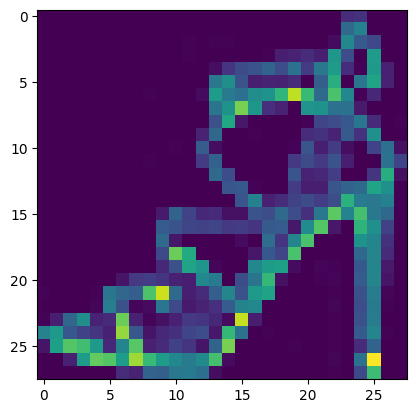

In [8]:
data_load = read_h5_numpy(
    filename='../data/fashion-mnist_{}x{}_train.h5'.format(X_proc.shape[1], X_proc.shape[2])
)

ind = 1000
# ind = 1001

plt.imshow(data_load['X'][ind,:,:])
plt.show()
